## Построение социальных графов. Меры центральности

**Задание 1 (10 баллов)** 

Прочитайте данные из ```emails.csv```. В колонке ```message``` содержится информация о письме. Вам нужно сформировать несколько таблиц по данным для комфортной работы. 

Во-первых, у Вас имеется информация от том от когдо было отправленно письмо и кому:

* ```From``` - email отправителя
* ```X-From``` - имя отправитела 
* ```To``` - email получателя 
* ```X-To``` - имя получателя

Каждому индивидууму нужно присвоить свой уникальный ```id``` и сформировать таблицу, где по нему можно получить ```email``` и имя.

Также Вам нужно сформировать таблицу, в которой по каждому письму будет содержаться: 

* Дата
* ```id``` отправителя
* ```id``` получателей (обратитие внимание на то, что одно письмо может получать несколько человек)
* Текст

In [1]:
import sys
sys.path.append('C:\Program Files\Anaconda3\Lib\site-packages')

In [2]:
import pandas as pd
import re
from tqdm import tqdm

In [3]:
emails = pd.read_csv('D:/baklazhan/Compling/programmimng_solutions/python_nlp-master/emails.csv')

In [2]:
#emails = pd.read_csv('C:/Users/ALapidus/Desktop/emails.csv')

In [4]:
#[emails_sample.iloc[i].message.replace('\n\t','').split('\n')[:18] for i in range(50, 100)]

In [96]:
emails_sample.iloc[7].message.replace('\n\t','').split('\n')

['Message-ID: <6526027.1075840338266.JavaMail.evans@thyme>',
 'Date: Wed, 28 Nov 2001 15:55:16 -0800 (PST)',
 'From: lisa_lawson@platts.com',
 "To: e-mail <.andy@enron.com>, e-mail <.chuck@enron.com>, e-mail <.dave@enron.com>, e-mail <.dave@enron.com>, e-mail <.david@enron.com>, don.baughman@enron.com, e-mail <.don@enron.com>, e-mail <.douglas.@enron.com>, dave.ernsberger@enron.com, e-mail <.griff.@enron.com>, e-mail <.jason@enron.com>, e-mail <.jim@enron.com>, e-mail <.joe@enron.com>, joe.errigo@enron.com, e-mail <.john.@enron.com>, brian.jordan@enron.com, e-mail <.'kenneth.@enron.com>, lisa.lawson@enron.com, e-mail <.lisa@enron.com>, e-mail <.'mike.@enron.com>, e-mail <.rick@enron.com>, e-mail <.scott@enron.com>, e-mail <.timothy@enron.com>, mike.wilczek@enron.com",
 'Subject: Into Cinergy Hourly Index for November 27, 2001',
 'Mime-Version: 1.0',
 'Content-Type: text/plain; charset=us-ascii',
 'Content-Transfer-Encoding: 7bit',
 'X-From: "Lawson, Lisa" <Lisa_Lawson@platts.com>@ENRON

In [5]:
emails_sample = emails.sample(n = 10000)

In [6]:
emails_sample = emails_sample.reset_index(drop = True)

In [107]:
def make_contacts_dict(df):
    contacts_dict = {}
    #mail_to_list = []
    for index, row in tqdm(df.iterrows()):
        meta = ''
        text = ''
        mail_from = ''
        name_from = ''
        mail_to_list = []
        name_to_list = []
        
        message_split = row['message'].split('\n\n')
        meta = message_split[0]
        text = '\n\n'.join(message_split[1:])
        meta_list = meta.replace('\n\t','').replace('\n ',' ').split('\n')
        for attr in meta_list:
            attr = attr.split(': ')
            if (attr[0] == 'From'):
                mail_from = attr[1]
            if (attr[0] == 'To'):
                mail_to_list = attr[1].split(', ')
            if (attr[0] == 'X-From'):
                name_from = attr[1]
            if (attr[0] == 'X-To'):
                #names = re.sub('([-\w\.() ]+),?([-\w\.() ]+) <[-\w\.]+@[-\w\.]+>', '\\1\\2', attr[1])
                #names_to = re.sub('([-\w\.() ]+),?([-\w\.() ]+) </O=ENRON/OU=NA/CN=RECIPIENTS/[-\w/=]+>','\\1\\2', names)
                names_to = re.sub('([-\w\.() ]+),?([-\w\.() ]+) <[-\w\./=@]+>', '\\1\\2', attr[1])
                names_to = (re.sub('("[-\w\.() ]+),?([-\w\.() ]+")' , '\\1\\2', names_to)).replace('"','')
                name_to_list = names_to.split(', ')
                
                """
                if ('"' in attr[1]):
                    name_to_list = re.findall(r'"(.*?)"', attr[1])
                elif ('</O=ENRON/OU=NA/CN=RECIPIENTS/' in attr[1]):
                    name_to_list = [re.sub(r'.+>,','', name) for name in attr[1].split('</O=ENRON/OU=NA/CN=RECIPIENTS/')]
                else:
                    name_to_list = attr[1].split(', ')
                """
        #print(mail_from, name_from)
        name_from = re.sub(r'<.*?>', '', name_from.replace('@ ENRON', ''))
        contacts_dict.setdefault(mail_from, name_from.strip())

        #if len(mail_to_list) != len(name_to_list):
         #   print(index, len(mail_to_list), len(name_to_list))
          #  print(mail_to_list)
           # print(name_to_list)
            #print('\n')
        
        if len(mail_to_list) > len(name_to_list):
            dif = len(mail_to_list) - len(name_to_list)
            for i in range(dif):
                name_to_list.append('')
        
        if (mail_to_list and name_to_list):
            for mail_to, name_to in zip(mail_to_list, name_to_list):
                name_to = re.sub(r'<.*?>', '', name_to.replace('@ ENRON', '').replace('(E-mail)', ''))
                name_to = re.sub(r'SF40#.+#', '', name_to)
                contacts_dict.setdefault(mail_to, name_to.strip())
                #print(index, mail_to, name_to)   
                
    return contacts_dict


In [7]:
def parse_emails(df):
    contacts_dict = {}
    parsed_emails = []
    
    for index, row in tqdm(df.iterrows()):
        email_dict = {}
        meta = ''
        text = ''
        mail_from = ''
        name_from = ''
        mail_to_list = []
        name_to_list = []
        
        message_split = row['message'].split('\n\n')
        meta = message_split[0]
        text = ('\n\n'.join(message_split[1:])).strip()
        email_dict.setdefault('text',text)
        
        meta_list = meta.replace('\n\t','').replace('\n ',' ').split('\n')
        for attr in meta_list:
            attr = attr.split(': ')
            if (attr[0] == 'Date'):
                date = attr[1]
                email_dict.setdefault('date',date)
            if (attr[0] == 'From'):
                mail_from = attr[1]
            if (attr[0] == 'To'):
                mail_to_list = attr[1].split(', ')
            if (attr[0] == 'X-From'):
                name_from = attr[1]
            if (attr[0] == 'X-To'):
                #names = re.sub('([-\w\.() ]+),?([-\w\.() ]+) <[-\w\.]+@[-\w\.]+>', '\\1\\2', attr[1])
                #names_to = re.sub('([-\w\.() ]+),?([-\w\.() ]+) </O=ENRON/OU=NA/CN=RECIPIENTS/[-\w/=]+>','\\1\\2', names)
                names_to = re.sub('([-\w\.() ]+),?([-\w\.() ]+) <[-\w\./=@]+>', '\\1\\2', attr[1])
                names_to = (re.sub('("[-\w\.() ]+),?([-\w\.() ]+")' , '\\1\\2', names_to)).replace('"','')
                name_to_list = names_to.split(', ')
                
                """
                if ('"' in attr[1]):
                    name_to_list = re.findall(r'"(.*?)"', attr[1])
                elif ('</O=ENRON/OU=NA/CN=RECIPIENTS/' in attr[1]):
                    name_to_list = [re.sub(r'.+>,','', name) for name in attr[1].split('</O=ENRON/OU=NA/CN=RECIPIENTS/')]
                else:
                    name_to_list = attr[1].split(', ')
                """
        #print(mail_from, name_from)
        name_from = re.sub(r'<.*?>', '', name_from.replace('@ ENRON', '').replace('@ENRON', ''))
        email_dict.setdefault('mail_from', mail_from)
        email_dict.setdefault('name_from', name_from)
        contacts_dict.setdefault(mail_from, name_from.strip())

        #if len(mail_to_list) != len(name_to_list):
         #   print(index, len(mail_to_list), len(name_to_list))
          #  print(mail_to_list)
           # print(name_to_list)
            #print('\n')
        
        if len(mail_to_list) > len(name_to_list):
            dif = len(mail_to_list) - len(name_to_list)
            for i in range(dif):
                name_to_list.append('')
        
        if (mail_to_list and name_to_list):
            email_dict.setdefault('mail_to', mail_to_list)
            email_dict.setdefault('name_to', name_to_list)
            for mail_to, name_to in zip(mail_to_list, name_to_list):
                name_to = re.sub(r'<.*?>', '', name_to.replace('@ ENRON', '').replace('(E-mail)', '').replace('@ENRON',''))
                name_to = re.sub(r'SF40#.+#', '', name_to)
                contacts_dict.setdefault(mail_to, name_to.strip())
                #print(index, mail_to, name_to)   
        parsed_emails.append(email_dict)       
    return contacts_dict, parsed_emails


In [5]:
names = 'Novosel, Sarah </O=ENRON/OU=NA/CN=RECIPIENTS/CN=NOTESADDR/CN=E8015336-2D09A27C-862566B9-5830A9>, Alvarez, Ray </O=ENRON/OU=NA/CN=RECIPIENTS/CN=NOTESADDR/CN=EBE4476B-2D94882A-86256A14-75FF3B>, Hartsoe, Joe </O=ENRON/OU=NA/CN=RECIPIENTS/CN=NOTESADDR/CN=AA8CC789-55F05846-862566B9-583A12>, Bagot, Nancy </O=ENRON/OU=NA/CN=RECIPIENTS/CN=NOTESADDR/CN=716CAD03-A5CB7D52-86256952-61A958>, Fulton, Donna </O=ENRON/OU=NA/CN=RECIPIENTS/CN=NOTESADDR/CN=CDE8DAE-A0B9AB37-862566B7-7A1609>, Briggs, Tom </O=ENRON/OU=NA/CN=RECIPIENTS/CN=NOTESADDR/CN=179E5C8C-206E9F55-8625691E-7D943>, Nersesian, Carin </O=ENRON/OU=NA/CN=RECIPIENTS/CN=NOTESADDR/CN=4CF0E754-2B22EC7C-86256A08-7190CA>, Comnes, Alan'

In [97]:
#names = 'Ward, Kim S (Houston) </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Kward>'
#names = 'Bland, Todd <Todd.Bland@ENRON.com>, Dean, Craig (Houston) <Craig.Dean@ENRON.com>, Guzman, Mark </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Mguzman3>, Harasin, Leaf </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Lharasin>, Linder, Eric </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Elinder>, Merriss, Steven </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Smerris>, Meyers, Bert </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Bmeyers>, Porter, David V. </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Dporter3>, Slinger, Ryan </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Rslinger>, Solberg, Geir </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Gsolber>, Symes, Kate </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Ksymes>, Williams III, Bill </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Bwillia5>'
names = 'Andy Tuschong (E-mail) <Andy.Tuschong@Cinergy.COM>, "Anthony\\" <Anthony. Due@\\"Due (E-mail)", Bob Brunner (E-mail) <bob.brunner@lgeenergy.com>, Chuck Whitlock (E-mail) <charles.whitlock@cinergy.com>, Dave Antonides (E-mail) <dantonides@DAYTONPOWER.com>, Dave Holder (E-mail) <dholder@aeglobalmarkets.com>, David Behrman (E-mail) <David_Behrman@platts.com>, Baughman Jr., Don </O=ENRON/OU=NA/CN=RECIPIENTS/CN=DBAUGHM>, Don Theriualt (E-mail) <detheriault@nisource.com>, Douglas. Lawrence (E-mail) <Douglas.Lawrence@dynegy.com>, Ernsberger, Dave <dave_ernsberger@platts.com>, Griff. E. Jones (E-mail) <Griff.E.Jones@dynegy.com>, Jason Earnheart (E-mail) <jason.earnheart@williams.com>, Jim Sadtler (E-mail) <jsadtler@ipalco.com>, Joe Belford (E-mail) <Joe.Belford@Cinergy.com>, Errigo, Joe </O=ENRON/OU=NA/CN=RECIPIENTS/CN=JERRIGO>, John. Tignor (E-mail) <john.tignor@engageenergy.com>, Jordan, Brian <brian_jordan@platts.com>, \'Kenneth. James (E-mail) <kenneth.james@williams.com>, Lawson, Lisa <Lisa_Lawson@platts.com>, Lisa Lawson (E-mail) <ll_mwdaily@yahoo.com>, \'Mike. Mushrush (E-mail) <mike.mushrush@williams.com>, Rick Abernathy (E-mail) <rjab@dynegy.com>, Ryan@Cinergy <ryan.gentil@cinergy.com>, Scott Burnside (E-mail) <Scott.Burnside@Cinergy.COM>, "Shannah\\" <Shannah. Goins \\"Goins (E-mail)"@ENRON, Teri Viswanath (E-mail) <Teri.Viswanath@dynegy.com>, Timothy B. Ferguson (E-mail) <tim.ferguson@cinergy.com>, Wilczek, Mike <mike_wilczek@platts.com>'

In [102]:
re.sub('([-\w\.() ]+),?([-\w\.() ]+) <[-\w\./=@]+>', '\\1\\2', names).split(', ')
#names = re.sub('([-\w\.() ]+),?([-\w\.() ]+) <[-\w\.]+@[-\w\.]+>', '\\1\\2', names)
#re.sub('([-\w\.() ]+),?([-\w\.() ]+) </O=ENRON/OU=NA/CN=RECIPIENTS/[-\w/=]+>','\\1\\2', names)



['Andy Tuschong (E-mail)',
 '"Anthony\\" <Anthony. Due@\\"Due (E-mail)"',
 'Bob Brunner (E-mail)',
 'Chuck Whitlock (E-mail)',
 'Dave Antonides (E-mail)',
 'Dave Holder (E-mail)',
 'David Behrman (E-mail)',
 'Baughman Jr. Don',
 'Don Theriualt (E-mail)',
 'Douglas. Lawrence (E-mail)',
 'Ernsberger Dave',
 'Griff. E. Jones (E-mail)',
 'Jason Earnheart (E-mail)',
 'Jim Sadtler (E-mail)',
 'Joe Belford (E-mail)',
 'Errigo Joe',
 'John. Tignor (E-mail)',
 'Jordan Brian',
 "'Kenneth. James (E-mail)",
 'Lawson Lisa',
 'Lisa Lawson (E-mail)',
 "'Mike. Mushrush (E-mail)",
 'Rick Abernathy (E-mail)',
 'Ryan@Cinergy',
 'Scott Burnside (E-mail)',
 '"Shannah\\" <Shannah. Goins \\"Goins (E-mail)"@ENRON Teri Viswanath (E-mail)',
 'Timothy B. Ferguson (E-mail)',
 'Wilczek Mike']

In [51]:
(re.sub('("[-\w\. ]+),?([-\w\. ]+")' , '\\1\\2', '"OTC, Dispatch" ghjl, "Joe, John" fjkldk;s|')).replace('"','')

'OTC Dispatch ghjl, Joe John fjkldk;s|'

In [111]:
#contacts_dict = make_contacts_dict(emails_sample)

10000it [00:09, 1018.89it/s]


In [8]:
contacts_dict, parsed_emails_list = parse_emails(emails_sample)

10000it [00:09, 1097.31it/s]


In [10]:
parsed_emails_list[:10]

[{'date': 'Wed, 15 Nov 2000 03:55:00 -0800 (PST)',
  'mail_from': 'lwbthemarine@bigplanet.com',
  'mail_to': ['daphneco64@bigplanet.com',
   'daphneco64@yahoo.com',
   'jason.bass2@compaq.com',
   'eric.bass@enron.com'],
  'name_from': '"Larry W. Bass" ',
  'name_to': ['KATHY BASS', 'kb', 'jason', 'eric preston bass'],
  'text': '?\n----- Original Message -----  \nFrom: kamelang  \nTo: Undisclosed-Recipient:; \nSent: Wednesday, November 15, 2000 11:40 AM\nSubject: Fw: NEVER DIAL AREA CODE 809\n\n?\n----- Original Message -----  \nFrom: Cherise Hayes \nTo: Tricia DuBois ; Rocky Stevens ; Robyn ; Mike M ; Mike A ; Melissa ; Karyn \n;  Brent Redus ; Brian  South ; Karl ; Julia ;  Jennifer  Carranza ; Frances \n; Dad ; Connie  ; Chad  Seger ; Bill  Roberts \nSent: Wednesday, November 15, 2000 11:12 AM\nSubject: Fw: NEVER DIAL AREA CODE 809\n\n<< <? DON\'T EVER DIAL AREA CODE 809 \n?  > > > > > \n? > > > > >This one is being  distributed all over the US.? This is pretty \n? scary \n?  > > >

In [ ]:
'ashley.a.mace@williams.com': '"Mace, Ashley A" @ENRON'

In [ ]:
Lynne Kenny \\(E-mail\\)
Mike Grigsby @ home (email)

In [11]:
contacts_dict

{'frank.sayre@enron.com': 'Frank Sayre',
 'jgalvan@kpmg.com': 'Galvan, Joshua P',
 'allan.p.sarman@boeing.com': 'allan.p.sarman@boeing.com',
 'annamarie.reed@enron.com': 'Annamarie Reed',
 'yolanda.cordova-gilbert@enron.com': 'Yolanda Cordova-Gilbert',
 'jeff.blumenthal@enron.com': 'Jeff Blumenthal',
 '211-6155@mcimail.com': 'dwatkiss@bracepatt.com',
 '#26.training@enron.com': 'Training User ID #25',
 'lisa.trofholz@enron.com': 'Trofholz Lisa',
 'chris.long@enron.com': 'Chris Long',
 'achen@us.ibm.com': 'achen@us.ibm.com',
 'liz.prior@enron.com': 'Prior Liz',
 'roberta.staehlin@enron.com': 'Evan Hughes',
 'lyman.wilkes@enron.com': 'Moscoso Michael E.',
 'james.lessor@enron.com': 'James N Lessor',
 'david.vitrella@enron.com': 'David J Vitrella',
 'lori.boudreaux@enron.com': 'Bir Marc',
 'fiske@haas.berkeley.edu': "'fiske@haas.berkeley.edu'",
 'lori.pinder@enron.com': 'Lori Pinder',
 'dick.uran@enron.com': 'Dick Uran',
 'mauricio.marquez@enron.com': 'Marquez Mauricio',
 'shemeika.landry@

In [12]:
emails_sample['parsed_emails'] = parsed_emails_list

In [13]:
emails_sample.head()

,file,message,parsed_emails
0,bass-e/all_documents/508.,Message-ID: <3260757.1075854589369.JavaMail.ev...,"{'name_from': '""Larry W. Bass"" ', 'date': 'Wed..."
1,rogers-b/all_documents/1795.,Message-ID: <19643874.1075857166470.JavaMail.e...,"{'name_from': 'Jinsung Myung', 'date': 'Mon, 2..."
2,lenhart-m/sent_items/22.,Message-ID: <10246817.1075845202294.JavaMail.e...,"{'name_from': 'Matthew Lenhart', 'date': 'Tue,..."
3,kaminski-v/all_documents/684.,Message-ID: <23860892.1075856197473.JavaMail.e...,"{'name_from': 'Tanya Tamarchenko', 'date': 'Mo..."
4,shively-h/inbox/16.,Message-ID: <18586877.1075840308237.JavaMail.e...,"{'name_from': 'Hodges, Georgeanne ', 'date': '..."


In [14]:
len(contacts_dict)

13243

In [15]:
contacts = pd.DataFrame(data = list(zip(contacts_dict.keys(), contacts_dict.values())), 
                       columns = ['email', 'name'])

In [16]:
contacts = contacts.reset_index()
contacts.columns = ['id', 'email','name']
contacts.head()

,id,email,name
0,0,frank.sayre@enron.com,Frank Sayre
1,1,jgalvan@kpmg.com,"Galvan, Joshua P"
2,2,allan.p.sarman@boeing.com,allan.p.sarman@boeing.com
3,3,annamarie.reed@enron.com,Annamarie Reed
4,4,yolanda.cordova-gilbert@enron.com,Yolanda Cordova-Gilbert


In [17]:
contacts.shape

(13243, 3)

In [22]:
def make_emails_df(raw_emails_df, contacts_df):
    dates = []
    texts = []
    id_from = []
    id_to = []
    
    for index, row in tqdm(raw_emails_df.iterrows()):
        parsed_message = row['parsed_emails']
        dates.append(parsed_message['date'])
        texts.append(parsed_message['text'])
        
        email_from = parsed_message['mail_from']
        id_from.append(int(contacts_df[contacts_df.email == email_from].id))
        
        try:
            emails_to_list = parsed_message['mail_to']
        except KeyError:
            emails_to_list = []
            
        id_to_list = []
        if emails_to_list:
            for email_to in emails_to_list:
                id_to_list.append(str(int(contacts_df[contacts_df.email == email_to].id)))
            id_to.append(','.join(id_to_list))
        else:
            id_to.append('')  
            
    emails_df = pd.DataFrame({'date':dates, 'id_from':id_from, 'id_to':id_to, 'text':texts})
    return emails_df

In [117]:
def make_emails_df(raw_emails_df, contacts_df):
    #contacts_dict = {}
    dates = []
    texts = []
    id_from = []
    id_to = []
    
    for index, row in tqdm(raw_emails_df.iterrows()):
        mail_to_list = []
        message_split = row['message'].split('\n\n')
        meta = message_split[0]
        text = ('\n\n'.join(message_split[1:])).strip()
        texts.append(text)
        meta_list = meta.replace('\n\t','').replace('\n ',' ').split('\n')
        for attr in meta_list:
            attr = attr.split(': ')
            if (attr[0] == 'Date'):
                date = attr[1]
            if (attr[0] == 'From'):
                mail_from = attr[1]
            if (attr[0] == 'To'):
                mail_to_list = attr[1].split(', ')
            #if (attr[0] == 'X-From'):
            #    name_from = attr[1]
            #if (attr[0] == 'X-To'):
            #    if ('"' in attr[1]):
            #        name_to_list = re.findall(r'"(.*?)"', attr[1])
            #    else:
            #        name_to_list = attr[1].split(', ')

        dates.append(date)
        #id_from.append(int(contacts_df[(contacts_df.email == mail_from)&(contacts_df.name == name_from)].id))
        id_from.append(int(contacts_df[contacts_df.email == mail_from].id))

        #id_to.append([contacts_df[(contacts_df.email == mail_to)&(contacts_df.name == name_to)].id for mail_to, name_to in zip(mail_to_list, name_to_list)])
        id_to_list = []
        if mail_to_list:
            for mail_to in mail_to_list:
                #print(contacts_df[(contacts_df.email == mail_to)&(contacts_df.name == name_to)].id)
                #print(mail_to, name_to)
                #id_to_list.append(str(int(contacts_df[(contacts_df.email == mail_to)&(contacts_df.name == name_to)].id)))
                #print(mail_to, contacts_df[contacts_df.email == mail_to].id)
                id_to_list.append(str(int(contacts_df[contacts_df.email == mail_to].id)))
            id_to.append(','.join(id_to_list))
        else:
            id_to.append('')
        
            #contacts_dict.setdefault(mail_to, name_to)
            #print(index, mail_to, name_to)
    emails_df = pd.DataFrame({'date':dates, 'id_from':id_from, 'id_to':id_to, 'text':texts})
    return emails_df

In [121]:
"""for index, row in emails_sample.iterrows():
    message_split = row['message'].split('\n\n')
    meta = message_split[0]
    #text = '\n\n'.join(message_split[1:])
    #texts.append(text)
    meta_list = meta.replace('\n\t','').replace('\n ',' ').split('\n')
    for attr in meta_list:
        attr = attr.split(': ')
        if (attr[0] == 'To'):
            if ('sscott3@enron.com, davef@jmbm.com' in attr[1]):
                print(index, meta)"""

"for index, row in emails_sample.iterrows():\n    message_split = row['message'].split('\n\n')\n    meta = message_split[0]\n    #text = '\n\n'.join(message_split[1:])\n    #texts.append(text)\n    meta_list = meta.replace('\n\t','').replace('\n ',' ').split('\n')\n    for attr in meta_list:\n        attr = attr.split(': ')\n        if (attr[0] == 'To'):\n            if ('sscott3@enron.com, davef@jmbm.com' in attr[1]):\n                print(index, meta)"

In [34]:
contacts_dict['constantine.brian@enron.com']

KeyError: 'constantine.brian@enron.com'

In [23]:
emails_df = make_emails_df(emails_sample, contacts)


10000it [10:25, 15.99it/s]


In [24]:
emails_df.head(20)

,date,id_from,id_to,text
0,"Wed, 15 Nov 2000 03:55:00 -0800 (PST)",11120,"9246,10414,12401,539",?\n----- Original Message ----- \nFrom: kamel...
1,"Mon, 28 Feb 2000 01:30:00 -0800 (PST)",3592,10887,Scott: Please see below.\n\n1. How much would...
2,"Tue, 17 Apr 2001 10:17:00 -0700 (PDT)",11719,8717,i thought that you said you were sharing a sui...
3,"Mon, 9 Apr 2001 10:13:00 -0700 (PDT)",6206,"6688,6114,8161,2399,5425,8235,12306,6553,3048,...","Everybody,\n\nthis week our regular meeting wi..."
4,"Tue, 5 Feb 2002 09:06:41 -0800 (PST)",8382,8771,In anticipation of the imminent closing of the...
5,"Mon, 26 Feb 2001 09:56:00 -0800 (PST)",3600,9512,Steve:\n\nI talked with Ben this afternoon and...
6,"Tue, 20 Feb 2001 08:21:00 -0800 (PST)",539,11067,---------------------- Forwarded by Eric Bass/...
7,"Fri, 28 Jul 2000 08:49:00 -0700 (PDT)",12912,"1632,12932,12905",Paul-welcome back. I have taken the following...
8,"Tue, 14 Mar 2000 23:45:00 -0800 (PST)",3820,3077,"Hey, I'm not going to the party tonight. My W..."
9,"Mon, 11 Dec 2000 05:39:00 -0800 (PST)",2474,"2474,9040,10464,1743,3787,6919,12677,12956,919...",If anyone has or expects to be able to respond...


In [25]:
emails_df[emails_df.id_to == ''].shape

(398, 4)

In [26]:
emails_df = emails_df[emails_df.id_to != '']

In [27]:
emails_df = emails_df.reset_index(drop=True)

In [28]:
emails_df.shape

(9602, 4)

In [29]:
contacts.shape

(13243, 3)

**Задание 2 (15 баллов)** 

Сформируйте матрицу $A = (a_{ij})_{i,j = 1}^N$, где $a_{ij}$ - количество писем, которое индивид $i$ отправил индивиду $j$, $N$ - количество индивидуумов

Далее из матрицы $A$ получим симметричную матрицу, которая будет показывать нам частоту коммуникаций между каждой парой индивидов: $A+A^T$. Постройте по данной матрице не направленный граф, где узлы должны называться по именам, которые вы извлекли из ```X-From``` и ```X-To```

**Замечание.** Так как граф слишком большой, то вы можете оставить только наиболее активных участников.

In [30]:
import numpy as np

In [31]:
def make_communication_matrix(df, contacts):
    N = contacts.shape[0]
    A = np.zeros((N,N))
    
    for index, row in df.iterrows():
        from_i = row['id_from']
        for to_j in row['id_to'].split(','):
            A[from_i][int(to_j)] += 1
    return A + np.transpose(A)
        

In [32]:
%%time
communication_matrix = make_communication_matrix(emails_df, contacts)

Wall time: 20.7 s


In [33]:
communication_matrix.shape

(13243, 13243)

In [34]:
max_com = communication_matrix.max()
max_com

326.0

In [35]:
communication_matrix.mean()

0.00069131052604266363

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
#plt.matshow(communication_matrix)
#plt.colorbar()

#plt.xticks(np.arange(N), le.classes_, rotation=90)
#plt.yticks(np.arange(N), le.classes_)

In [37]:
import networkx as nx

In [39]:
commun_measures = []
i, j = np.where(communication_matrix > 20)
for i_num, j_num in zip(i,j):
 #   if i_num > j_num:
    commun_measures.append(communication_matrix[i_num][j_num])
print(len(i))

98


In [40]:
commun_measures = commun_measures/max_com

In [41]:
communications = pd.DataFrame({'source':i, 'target':j, 'weight': commun_measures})

In [42]:
communications.head()

,source,target,weight
0,726,2599,0.082822
1,747,10700,0.064417
2,884,9803,0.064417
3,898,10402,0.098160
4,961,7363,0.067485


In [43]:
labels = dict(zip(contacts.id, contacts.name))

In [44]:
communications['source_name'] = [labels[source_id] for source_id in communications.source]
communications['target_name'] = [labels[target_id] for target_id in communications.target]

In [45]:
communications.head()

,source,target,weight,source_name,target_name
0,726,2599,0.082822,Maureen McVicker,Steven J Kean
1,747,10700,0.064417,Tana Jones,Mark Taylor
2,884,9803,0.064417,Dan Leff,Jeff Dasovich
3,898,10402,0.098160,Kerri Thompson,Kate Symes
4,961,7363,0.067485,James Wright,Susan J Mara


C:\Program Files\Anaconda3\envs\mllecture\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Program Files\Anaconda3\envs\mllecture\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Program Files\Anaconda3\envs\mllecture\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Program Files\Anaconda3\envs\mllecture\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed

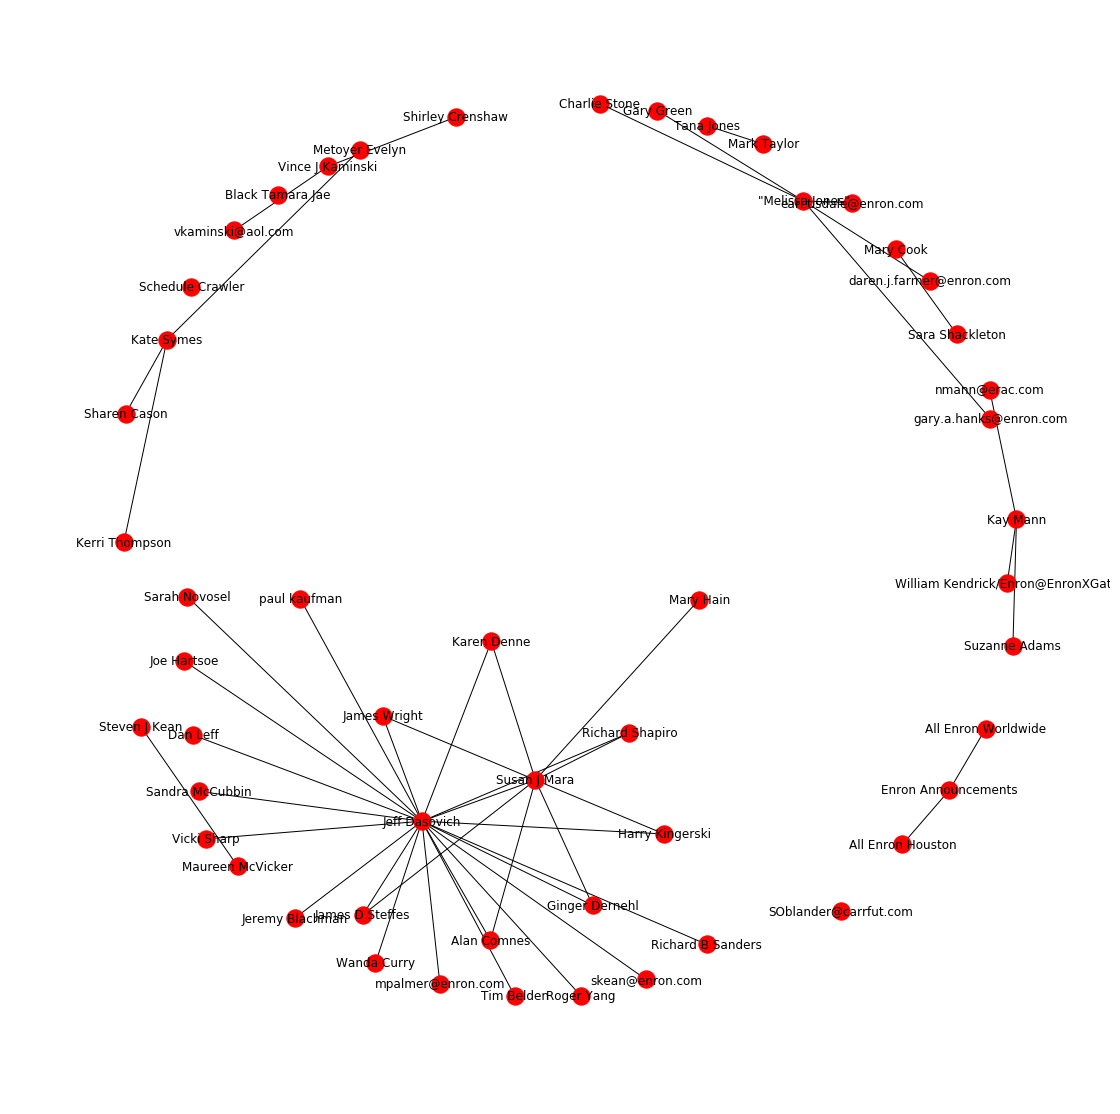

In [46]:
G = nx.from_pandas_dataframe(communications, 'source_name', 'target_name')

plt.figure(figsize=(15, 15))
nx.draw(G, with_labels = True)
plt.show()

**Задание 3 (25 баллов)**

Оцените важность отдельных узлов, используя следующие меры:

* Degree centrality
* Closeness centrality
* Betweenness centrality
* Eigenvector centrality

Подробнее читайте в статье: УЗЛЫ В СОЦИАЛЬНЫХ СЕТЯХ: МЕРЫ ЦЕНТРАЛЬНОСТИ И РОЛЬ В СЕТЕВЫХ ПРОЦЕССАХ

Для каждой меры центральности выведите топ пользователей

In [47]:
sorted(nx.degree_centrality(G).items(), key = lambda x: x[1], reverse = True)[:20]

[('Jeff Dasovich', 0.4117647058823529),
 ('Susan J Mara', 0.21568627450980393),
 ('"Melissa Jones"', 0.09803921568627451),
 ('Kate Symes', 0.058823529411764705),
 ('Kay Mann', 0.058823529411764705),
 ('Black Tamara Jae', 0.0392156862745098),
 ('Richard Shapiro', 0.0392156862745098),
 ('James Wright', 0.0392156862745098),
 ('Harry Kingerski', 0.0392156862745098),
 ('Vince J Kaminski', 0.0392156862745098),
 ('Ginger Dernehl', 0.0392156862745098),
 ('Schedule Crawler', 0.0392156862745098),
 ('Karen Denne', 0.0392156862745098),
 ('SOblander@carrfut.com', 0.0392156862745098),
 ('James D Steffes', 0.0392156862745098),
 ('Alan Comnes', 0.0392156862745098),
 ('Enron Announcements', 0.0392156862745098),
 ('gary.a.hanks@enron.com', 0.0196078431372549),
 ('Jeremy Blachman', 0.0196078431372549),
 ('Kerri Thompson', 0.0196078431372549)]

In [48]:
sorted(nx.closeness_centrality(G).items(), key = lambda x: x[1], reverse = True)[:20]

[('Jeff Dasovich', 0.41261722080136404),
 ('Susan J Mara', 0.27114845938375354),
 ('Richard Shapiro', 0.22595704948646128),
 ('James Wright', 0.22595704948646128),
 ('Harry Kingerski', 0.22595704948646128),
 ('Ginger Dernehl', 0.22595704948646128),
 ('Karen Denne', 0.22595704948646128),
 ('James D Steffes', 0.22595704948646128),
 ('Alan Comnes', 0.22595704948646128),
 ('Jeremy Blachman', 0.21568627450980393),
 ('paul kaufman', 0.21568627450980393),
 ('Richard B Sanders', 0.21568627450980393),
 ('Wanda Curry', 0.21568627450980393),
 ('Joe Hartsoe', 0.21568627450980393),
 ('Tim Belden', 0.21568627450980393),
 ('Roger Yang', 0.21568627450980393),
 ('Dan Leff', 0.21568627450980393),
 ('Vicki Sharp', 0.21568627450980393),
 ('Sarah Novosel', 0.21568627450980393),
 ('Sandra McCubbin', 0.21568627450980393)]

In [49]:
sorted(nx.betweenness_centrality(G).items(), key = lambda x: x[1], reverse = True)[:20]

[('Jeff Dasovich', 0.16117647058823528),
 ('Susan J Mara', 0.024705882352941175),
 ('"Melissa Jones"', 0.00784313725490196),
 ('Kate Symes', 0.002352941176470588),
 ('Kay Mann', 0.002352941176470588),
 ('Vince J Kaminski', 0.000784313725490196),
 ('Enron Announcements', 0.000784313725490196),
 ('gary.a.hanks@enron.com', 0.0),
 ('Jeremy Blachman', 0.0),
 ('Kerri Thompson', 0.0),
 ('Steven J Kean', 0.0),
 ('Black Tamara Jae', 0.0),
 ('paul kaufman', 0.0),
 ('Richard Shapiro', 0.0),
 ('James Wright', 0.0),
 ('Shirley Crenshaw', 0.0),
 ('Harry Kingerski', 0.0),
 ('Tana Jones', 0.0),
 ('All Enron Worldwide', 0.0),
 ('Richard B Sanders', 0.0)]

In [50]:
sorted(nx.eigenvector_centrality(G).items(), key = lambda x: x[1], reverse = True)[:20]

[('Jeff Dasovich', 0.5981659756046342),
 ('Susan J Mara', 0.460871232646843),
 ('Richard Shapiro', 0.1947095389481105),
 ('James Wright', 0.1947095389481105),
 ('Harry Kingerski', 0.1947095389481105),
 ('Ginger Dernehl', 0.1947095389481105),
 ('Karen Denne', 0.1947095389481105),
 ('James D Steffes', 0.1947095389481105),
 ('Alan Comnes', 0.1947095389481105),
 ('Jeremy Blachman', 0.10997652066126029),
 ('paul kaufman', 0.10997652066126029),
 ('Richard B Sanders', 0.10997652066126029),
 ('Wanda Curry', 0.10997652066126029),
 ('Joe Hartsoe', 0.10997652066126029),
 ('Tim Belden', 0.10997652066126029),
 ('Roger Yang', 0.10997652066126029),
 ('Dan Leff', 0.10997652066126029),
 ('Vicki Sharp', 0.10997652066126029),
 ('Sarah Novosel', 0.10997652066126029),
 ('Sandra McCubbin', 0.10997652066126029)]

**Бонусное задание (25 баллов)** 

Выделите темы, которые обсуждаются в письмах.

Выберите одну из мер центральности и для топа пользователей по данной мере укажите, какие темы они обсуждают чаще всего и с кем.